# Data loading and segmentation

## Loading and exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16268845726840421608
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 781516294644201059
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
!pip install openpyxl

In [ ]:
data = pd.read_csv('/content/bus_data.csv')

In [ ]:
data.head()

,ID,Case,Histology,Pathology,BIRADS,Device,Width,Height,Side,BBOX
0,bus_0001-l,1,invasive ductal carcinoma,malignant,4,GE Logiq 7 @10-14MHz,274,353,left,"[91,24,103,79]"
1,bus_0001-r,1,invasive ductal carcinoma,malignant,4,GE Logiq 7 @10-14MHz,275,353,right,"[102,24,82,79]"
2,bus_0002-l,2,fibroadenoma,benign,4,GE Logiq 7 @10-14MHz,274,371,left,"[134,142,88,50]"
3,bus_0002-r,2,fibroadenoma,benign,4,GE Logiq 7 @10-14MHz,276,371,right,"[113,143,68,47]"
4,bus_0003-l,3,invasive ductal carcinoma,malignant,4,GE Logiq 7 @10-14MHz,275,372,left,"[71,78,126,137]"


In [ ]:
data.shape

(1875, 10)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1875 non-null   object
 1   Case       1875 non-null   int64 
 2   Histology  1875 non-null   object
 3   Pathology  1875 non-null   object
 4   BIRADS     1875 non-null   int64 
 5   Device     1875 non-null   object
 6   Width      1875 non-null   int64 
 7   Height     1875 non-null   int64 
 8   Side       1875 non-null   object
 9   BBOX       1875 non-null   object
dtypes: int64(4), object(6)
memory usage: 146.6+ KB


In [ ]:
data.describe()

,Case,BIRADS,Width,Height
count,1875.000000,1875.000000,1875.000000,1875.000000
mean,517.461333,3.237333,321.310400,391.289600
std,307.787481,0.973882,76.917971,52.873259
min,1.000000,2.000000,240.000000,268.000000
25%,255.500000,2.000000,276.000000,350.000000
50%,497.000000,3.000000,286.000000,383.000000
75%,786.500000,4.000000,323.000000,435.000000
max,1064.000000,5.000000,579.000000,478.000000


In [ ]:
categorical_columns = ['Histology', 'Pathology', 'BIRADS', 'Side']

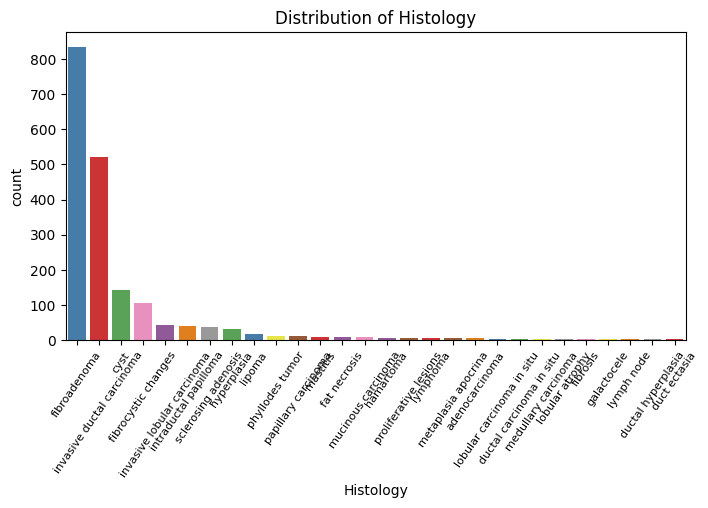

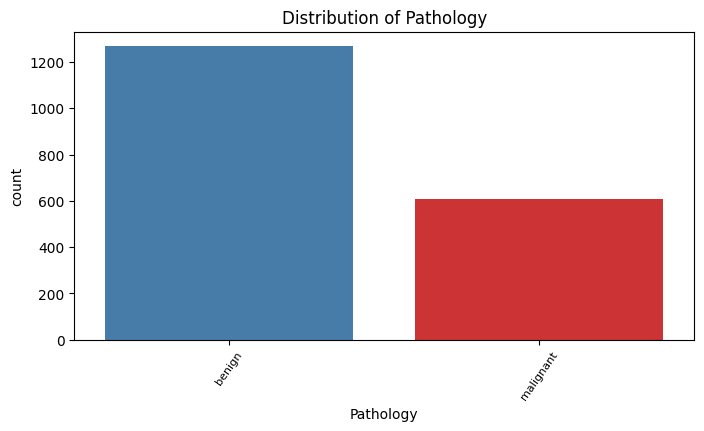

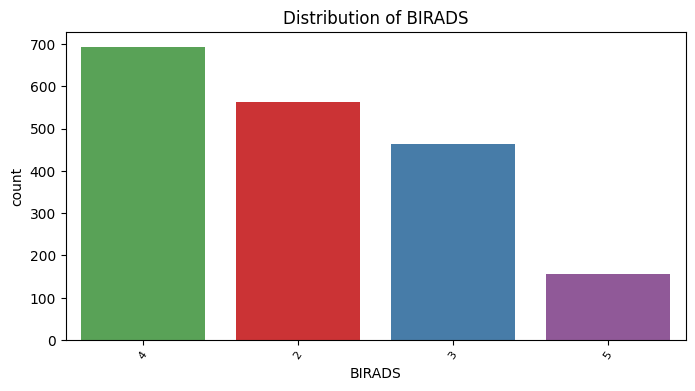

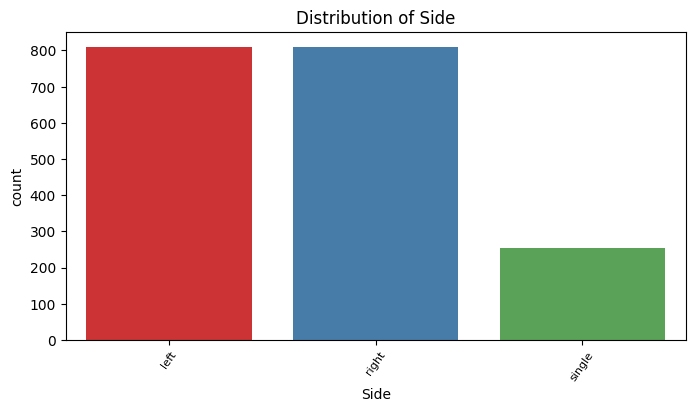

In [ ]:
def plot_categorical_distribution(column):
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=column, hue=column, order=data[column].value_counts().index, palette='Set1', legend=False)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=55, fontsize=8)
    plt.show()

for col in categorical_columns:
    plot_categorical_distribution(col)


In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data['Pixel_size'], bins=30, kde=True, color='blue')
plt.title('Distribution of Pixel Size')
plt.xlabel('Pixel Size')
plt.ylabel('Frequency')
plt.show()

In [ ]:
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data['Age'], bins=30, kde=True, color='purple')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

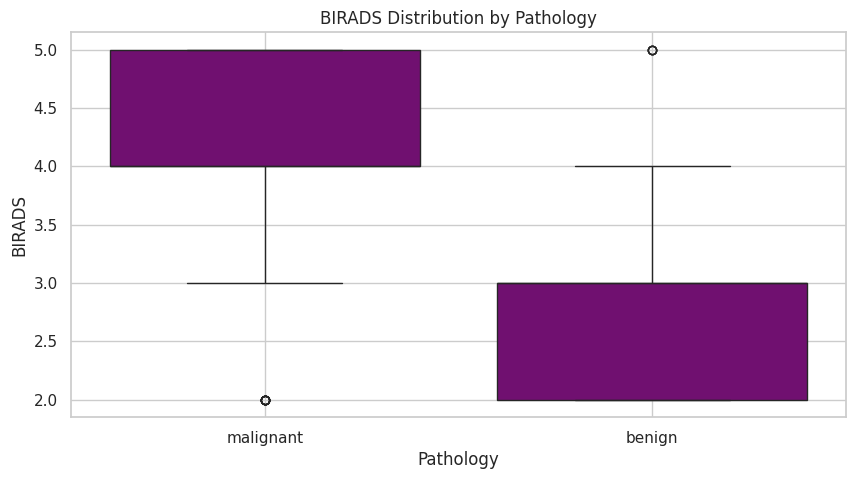

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
sns.boxplot(x= data['Pathology'], y= data['BIRADS'], data=data, color='purple')
plt.title('BIRADS Distribution by Pathology')
plt.xlabel('Pathology')
plt.ylabel('BIRADS')
plt.grid(True)
plt.show()

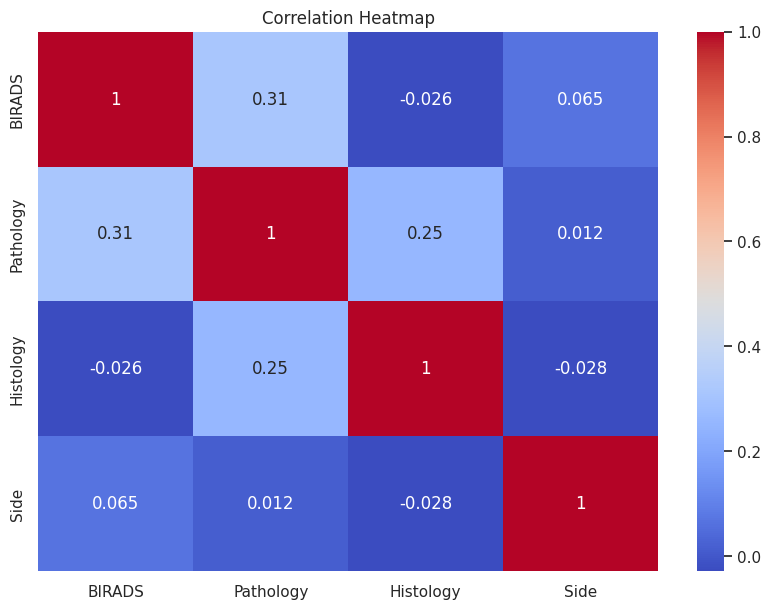

In [ ]:
plt.figure(figsize=(10, 7))
selected_columns = ['BIRADS', 'Pathology', 'Histology', 'Side']
sns.heatmap(data[selected_columns].apply(lambda x: pd.factorize(x)[0]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
isMalignant = data[data['Pathology'] == 'malignant']
print("Malignant: ",len(isMalignant))
isBenign = data[data['Pathology'] == 'benign']
print("Benign: ",len(isBenign))

Malignant:  607
Benign:  1268


## U-Net

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images_dir = "/content/drive/My Drive/BUS-BRA_dataset/Images"
masks_dir = "/content/drive/My Drive/BUS-BRA_dataset/Masks"

In [ ]:
def load_images_and_masks(images_dir, masks_dir, img_size=256):
    images = []
    masks = []
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img = load_img(os.path.join(images_dir, img_file), target_size=(img_size, img_size))
        mask = load_img(os.path.join(masks_dir, mask_file), target_size=(img_size, img_size), color_mode="grayscale")

        img_array = img_to_array(img) / 255.0  # Normalize
        mask_array = img_to_array(mask) / 255.0  # Normalize
        mask_array = (mask_array > 0.5).astype(np.float32)

        images.append(img_array)
        masks.append(mask_array)

    return np.array(images), np.array(masks)


Images shape: (1875, 256, 256, 3)
Masks shape: (1875, 256, 256, 1)


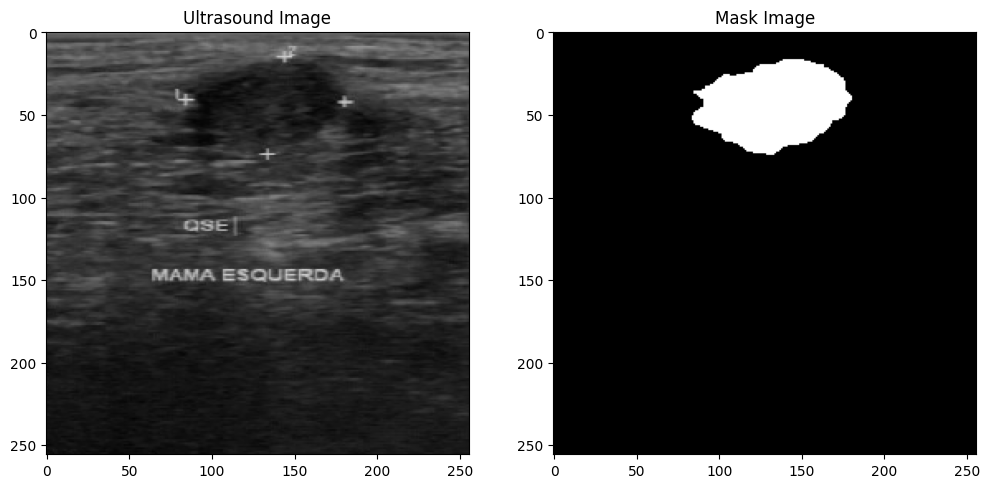

In [ ]:

images, masks = load_images_and_masks(images_dir, masks_dir)
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Ultrasound Image")
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Mask Image")
plt.imshow(masks[0].squeeze(), cmap="gray")
plt.show()


In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
SEED = 42

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=SEED)

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}")

Training data: (1500, 256, 256, 3), Validation data: (375, 256, 256, 3)


**U-net Architecture:**

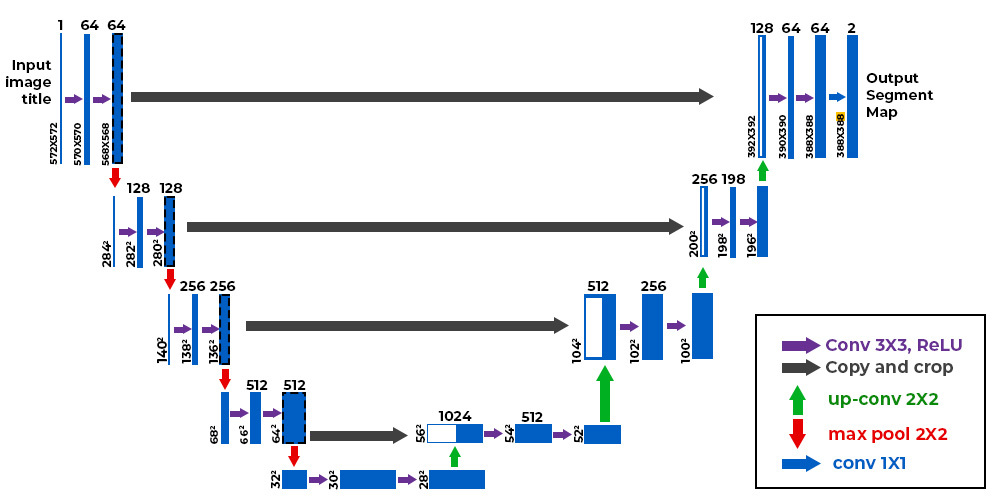

image source: GFG

In [ ]:
from tensorflow.keras import layers, Model
import tensorflow as tf

# Custom Dice Loss Function
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder: Downsampling
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    # Dropout Layer
    c5 = layers.Dropout(0.5)(c5)

    # Decoder: Upsampling
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

model_unet = unet_model()
model_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=dice_loss , metrics=["accuracy"])
model_unet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,055,041 (118.47 MB)

 Trainable params: 31,043,393 (118.42 MB)

 Non-trainable params: 11,648 (45.50 KB)

In [ ]:
def dice_score(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


In [ ]:
model_unet.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy', dice_score])

history = model_unet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=35
)

Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


47/47 ━━━━━━━━━━━━━━━━━━━━ 397s 6s/step - accuracy: 0.8839 - dice_score: 0.1927 - loss: 0.3164 - val_accuracy: 0.0937 - val_dice_score: 0.1654 - val_loss: 1288.0007
Epoch 2/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9419 - dice_score: 0.4834 - loss: 0.1573 - val_accuracy: 0.1626 - val_dice_score: 0.1766 - val_loss: 17.5763
Epoch 3/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9578 - dice_score: 0.6280 - loss: 0.1144 - val_accuracy: 0.2476 - val_dice_score: 0.1919 - val_loss: 12.2986
Epoch 4/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9628 - dice_score: 0.6753 - loss: 0.0983 - val_accuracy: 0.4246 - val_dice_score: 0.2251 - val_loss: 3.1846
Epoch 5/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9679 - dice_score: 0.7291 - loss: 0.0860 - val_accuracy: 0.3852 - val_dice_score: 0.2218 - val_loss: 4.2356
Epoch 6/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9695 - dice_score: 0.7427 - loss: 0.0800 - val_accuracy: 0.9056 - val_dice_sc

In [ ]:
val_loss, val_accuracy, val_dice_score = model_unet.evaluate(X_val, y_val)

# Print the evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Dice Score: {val_dice_score}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 582ms/step - accuracy: 0.9774 - dice_score: 0.8608 - loss: 0.0881
Validation Loss: 0.09452085196971893
Validation Accuracy: 0.9771853685379028
Validation Dice Score: 0.8570168018341064


In [ ]:
model_unet.save('saved_unet_model.keras')
print("Saved model to saved_unet_model.keras")

Saved model to saved_unet_model.keras
